In [ ]:
# =======================
# Cell 1: Load Data
# =======================
import pandas as pd

# Google Sheet CSV link (replace with your updated sheet's link)
csv_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSzCycj_GQPRP3U6w06adXjsk2gIxKxFJ2vt2hsbQ9QIJCgTceQ7WAW4Am9ESadO7G1kd0bjTYS0jcm/pub?gid=42333375&single=true&output=csv"

# Load into DataFrame
df = pd.read_csv(csv_url)

print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset info:")
print(df.info())






First 5 rows of the dataset:
  Bill Number  Year                                              Title  \
0   H.R. 4829  2018  To promote a 21st century artificial intellige...   
1     S. 3502  2018               National AI Research Advancement Act   
2   H.R. 2575  2019             Algorithmic Accountability Act of 2019   
3     S. 1363  2019                  National AI Research Resource Act   
4   H.R. 7096  2019                     Algorithmic Bias Reduction Act   

                               Subfields  \
0    Job Security; General Ethical Usage   
1  Push for AI Research; Policy Advisory   
2      Data Usage; General Ethical Usage   
3  Push for AI Research; Data Usage; AGI   
4      Data Usage; General Ethical Usage   

                 Failure Reason/ or Passed  \
0             Stalled in Committee (House)   
1            Stalled in Committee (Senate)   
2  Passed House; Senate Calendar Inaction    
3                 Senate Calendar Inaction   
4             Stalled in Commit

In [ ]:
# =======================
# Cell 2: Feature Engineering
# =======================

from sklearn.preprocessing import LabelEncoder

# Step 0: Clean up column names to match Python-friendly style
df.rename(columns={
    'Bipartisan?': 'Bipartisan',
    '# of Sponsors': 'Num_Sponsors',
    'Failure Reason/ or Passed': 'Failure_Reason',
    'Stalled in Committee? (1 Yes/0 No)': 'Stalled',
    'Introduced Month': 'Introduced_Month'
}, inplace=True)

# NEW Step 0.5: Clean and standardize 'Subfields' strings to avoid duplicate dummy columns
df['Subfields'] = df['Subfields'].fillna('Unknown').apply(
    lambda x: ';'.join(sorted(set([s.strip().title() for s in str(x).split(';') if s.strip()])))
)

# Step 1: Create dummy variables for 'Subfields'
subfields_dummies = df['Subfields'].str.get_dummies(sep=';')

# Step 2: Ensure 'Committee' column exists and fill missing values
if 'Committee' not in df.columns:
    df['Committee'] = 'Unknown'
else:
    df['Committee'] = df['Committee'].fillna('Unknown')

# Also fill missing values in other categorical columns to prevent LabelEncoder issues
for col in ['Failure_Reason', 'Chamber', 'Sponsor Party', 'Bipartisan', 'Introduced_Month']:
    df[col] = df[col].fillna('Unknown')

# Step 3: Define categorical columns
categorical_cols = [
    'Failure_Reason',
    'Chamber',
    'Sponsor Party',
    'Bipartisan',
    'Introduced_Month',
    'Committee'
]

# Step 4: Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)  # Ensure all are strings
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Step 5: Combine all features into X
X = pd.concat([
    df[['Year', 'Num_Sponsors']].fillna(0),  # fill numeric NaNs with 0 or another strategy
    subfields_dummies,
    df[[f'{col}_encoded' for col in categorical_cols]]
], axis=1)

# Step 6: Target variable
y = df['Stalled'].fillna(0).astype(int)  # Fill missing and ensure integer type

print("\nFeature matrix preview:")
print(X.head())
print("\nTarget preview:")
print(y.head())



Feature matrix preview:
   Year  Num_Sponsors  Agi  Ai In Government  Autonomous Driving  Data Usage  \
0  2018            15    0                 0                   0           0   
1  2018             4    0                 0                   0           0   
2  2019             2    0                 0                   0           1   
3  2019             6    1                 0                   0           1   
4  2019             9    0                 0                   0           1   

   Deepfake  General Ethical Usage  Job Security  Large Language Models  \
0         0                      1             1                      0   
1         0                      0             0                      0   
2         0                      1             0                      0   
3         0                      0             0                      0   
4         0                      1             0                      0   

   Policy Advisory  Push For Ai Research  U

In [ ]:
# =======================
# Cell 3: Model Training & Evaluation
# =======================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("\nAccuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy on test set: 0.72

Confusion Matrix:
[[ 2  1]
 [ 6 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.94      0.73      0.82        22

    accuracy                           0.72        25
   macro avg       0.60      0.70      0.59        25
weighted avg       0.86      0.72      0.77        25



In [ ]:
# =======================
# Cell 4: Feature Importance Analysis
# =======================

# Fix feature names to replace any incorrect "Num_Average" with "Num_Sponsors"
fixed_feature_names = [feat if 'Num_' not in feat else 'Num_Sponsors' for feat in X.columns]

# Get the coefficients from the trained model
feature_importance = pd.DataFrame({
    'Feature': fixed_feature_names,
    'Coefficient': model.coef_[0]
})

# Sort by absolute value of coefficients (strongest effect first)
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print("\nAll features influencing whether a bill stalls in committee:")
print(feature_importance)  # Show all rows

# Optional: Show positive vs negative influence
print("\nInterpretation:")
print("Positive Coefficient  → More likely to stall")
print("Negative Coefficient → Less likely to stall")



All features influencing whether a bill stalls in committee:
                     Feature  Coefficient  Abs_Coefficient
14           Chamber_encoded    -1.307220         1.307220
8               Job Security    -0.757276         0.757276
13    Failure_Reason_encoded     0.755333         0.755333
15     Sponsor Party_encoded     0.744810         0.744810
5                 Data Usage    -0.614481         0.614481
2                        Agi    -0.592125         0.592125
11      Push For Ai Research     0.566376         0.566376
10           Policy Advisory    -0.512752         0.512752
16        Bipartisan_encoded    -0.507567         0.507567
17  Introduced_Month_encoded    -0.432645         0.432645
9      Large Language Models    -0.402035         0.402035
4         Autonomous Driving    -0.327645         0.327645
1               Num_Sponsors     0.187544         0.187544
7      General Ethical Usage     0.131796         0.131796
6                   Deepfake     0.093378         0.0

In [ ]:
# =======================
# Cell 5: Stall Likelihood by Category
# =======================

# Function to calculate and display stall rates, excluding 'Unknown'
def avg_stall_rate_by_category(df, col):
    # Filter out 'Unknown' values before grouping if present
    filtered_df = df[df[col].notna() & (df[col] != 'Unknown')]
    stall_rates = filtered_df.groupby(col)['Stalled'].mean().sort_values(ascending=False)
    print(f"\nAverage stall rate by {col}:")
    print(stall_rates)
    return stall_rates

# 1. Chamber (usually no 'Unknown' but keep same function)
avg_stall_rate_by_category(df, 'Chamber')

# 2. Sponsor Party (remove 'Unknown')
avg_stall_rate_by_category(df, 'Sponsor Party')

# 3. Introduced Month (remove 'Unknown')
avg_stall_rate_by_category(df, 'Introduced_Month')



Average stall rate by Chamber:
Chamber
House     0.894737
Senate    0.729167
Name: Stalled, dtype: float64

Average stall rate by Sponsor Party:
Sponsor Party
Independent    1.000000
Republican     0.939394
Democrat       0.825581
Name: Stalled, dtype: float64

Average stall rate by Introduced_Month:
Introduced_Month
August       1.000000
February     1.000000
March        1.000000
January      1.000000
November     1.000000
September    0.941176
June         0.933333
April        0.833333
December     0.833333
July         0.809524
May          0.611111
October      0.333333
Name: Stalled, dtype: float64


,Stalled
Introduced_Month,
August,1.000000
February,1.000000
March,1.000000
January,1.000000
November,1.000000
September,0.941176
June,0.933333
April,0.833333
December,0.833333


/tmp/ipython-input-590198191.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chamber', y='Stalled', data=stall_by_chamber, palette='pastel')
/tmp/ipython-input-590198191.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sponsor Party', y='Stalled', data=stall_by_party, palette='muted')
/tmp/ipython-input-590198191.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Introduced_Month', y='Stalled', data=stall_by_month_sorted, palette='coolwarm')


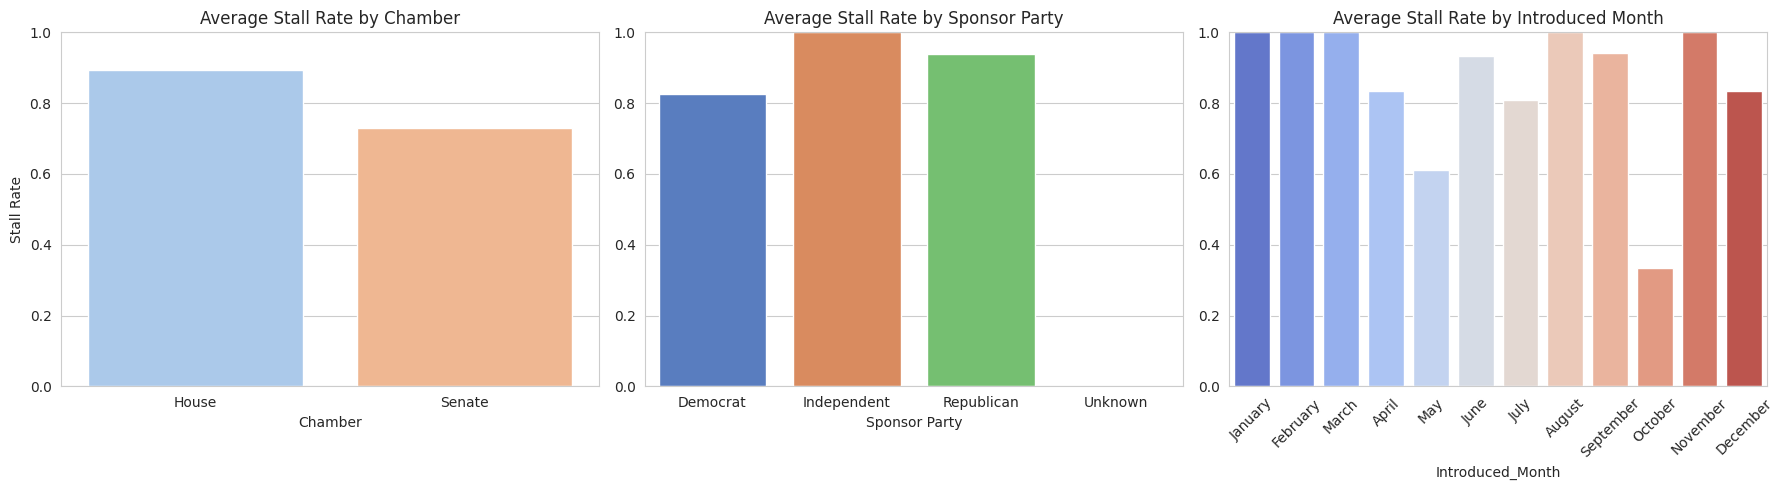

In [ ]:
# =======================
# Cell 6: Visualization of Stall Rates
# =======================
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plots
stall_by_chamber = df.groupby('Chamber')['Stalled'].mean().reset_index()
stall_by_party = df.groupby('Sponsor Party')['Stalled'].mean().reset_index()
stall_by_month = df.groupby('Introduced_Month')['Stalled'].mean().reset_index()

# Set figure size and style
plt.figure(figsize=(18,5))
sns.set_style('whitegrid')

# Plot 1: Stall Rate by Chamber
plt.subplot(1, 3, 1)
sns.barplot(x='Chamber', y='Stalled', data=stall_by_chamber, palette='pastel')
plt.title('Average Stall Rate by Chamber')
plt.ylabel('Stall Rate')
plt.ylim(0, 1)

# Plot 2: Stall Rate by Sponsor Party
plt.subplot(1, 3, 2)
sns.barplot(x='Sponsor Party', y='Stalled', data=stall_by_party, palette='muted')
plt.title('Average Stall Rate by Sponsor Party')
plt.ylabel('')
plt.ylim(0, 1)

# Plot 3: Stall Rate by Introduced Month
plt.subplot(1, 3, 3)
# Sort months in calendar order if needed
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
stall_by_month_sorted = stall_by_month.set_index('Introduced_Month').reindex(month_order).reset_index()

sns.barplot(x='Introduced_Month', y='Stalled', data=stall_by_month_sorted, palette='coolwarm')
plt.title('Average Stall Rate by Introduced Month')
plt.ylabel('')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
